# Compute pixel intensity range for each channel in each plate
Author: Jess Ewald

We want to plot images with an absolute intensity range such that the abundance can be compared across wells. Unfortunately the entire distribution of intensities seems different across different plates. Here, we read in the negative control wells and use them to compute the range of pixel values. 

In [1]:
# Imports
import polars as pl
import numpy as np
from sh import aws
import os
from skimage.io import imread
from matplotlib import pyplot as plt
import matplotlib as mpl
import random
from pathlib import Path

from importlib import reload
import displayImages as di
reload(di)

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import warnings
warnings.filterwarnings("ignore")

DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


<IPython.core.display.Javascript object>

In [2]:
# Directories
pm_dir = "/dgx1nas1/storage/data/jess/varchamp/platemaps"
sc_res = "/dgx1nas1/storage/data/jess/varchamp/sc_data"
plot_dir = "/dgx1nas1/storage/data/jess/varchamp/images/control_qaqc"

In [3]:
# concatenate all platemaps
pms = ["B7A1R1_P1.txt", "B7A1R1_P2.txt", "B7A1R1_P3.txt", "B7A1R1_P4.txt", "B7A2R1_P1.txt", "B8A1R2_P1.txt", "B8A1R2_P2.txt", "B8A1R2_P3.txt", "B8A1R2_P4.txt", "B8A2R2_P1.txt"]

pm_dfs = []
for pm in pms:
    try:
        temp = pl.read_csv(f"{pm_dir}/{pm}", separator="\t").select(['plate_map_name', 'well_position', 'control_type', 'gene_allele'])
        pm_dfs.append(temp)
    except Exception as e:
        print("Error reading {pm}: {e}")
    
pm_df = pl.concat(pm_dfs)

In [4]:
# Compute intensity ranges for each channel for each plate
ncs = pm_df.filter(pl.col("control_type") == "NC")
nc_alleles = ncs.select(["plate_map_name", "well_position", "gene_allele"]).unique().rename({"well_position": "Well",
                                                                                             "plate_map_name": "Plate"})

plates = pm_df.select("plate_map_name").to_series().unique().to_list()
reps = ["T1", "T2", "T3", "T4"]
channels = ["DAPI", "AGP", "Mito", "GFP"]


In [ ]:
# # For each platemap-TR-channel, read in pixel intensities from 5th site (middle) of all negative control (16 wells per plate)
# for plate in plates:
#     sampled_intensities = []
#     nc_temp = ncs.filter(pl.col("plate_map_name") == plate)
#     for rep in reps:
#         for channel in channels:
#             print(plate + ", " + rep + ", " + channel)
#             nc_wells = nc_temp.select("well_position").to_series().to_list()
            
#             for i in list(range(0,len(nc_wells))):
#                 try:
#                     sampled_intensities.append(di.getIntensities(plate, rep, channel, nc_wells[i], "05"))
#                 except Exception as e:
#                     print("Error: " + nc_wells[i])                       
#     sampled_intensities = pl.concat(sampled_intensities)  
#     sampled_intensities.write_parquet(f"{sc_res}/control_intensities/{plate}.parquet", compression="gzip")

In [ ]:
# # read in each plate and compute percentiles 
# allele_percs = []
# well_percs = []
# nc_symbols = nc_alleles.select(["Well", "gene_allele"]).unique()
# for plate in plates:
#     print(plate)
#     intensity = pl.read_parquet(f"{sc_res}/control_intensities/{plate}.parquet")
#     intensity = intensity.join(nc_symbols, on="Well")
    
#     allele_percs.append(
#         intensity.group_by(["Plate", "Replicate", "Channel", "gene_allele"]).agg([
#             pl.col('pixel_int').quantile(0.01).alias('perc01'),
#             pl.col('pixel_int').quantile(0.05).alias('perc05'),
#             pl.col('pixel_int').quantile(0.25).alias('perc25'),
#             pl.col('pixel_int').quantile(0.50).alias('perc50'),
#             pl.col('pixel_int').quantile(0.75).alias('perc75'),
#             pl.col('pixel_int').quantile(0.95).alias('perc95'),
#             pl.col('pixel_int').quantile(0.99).alias('perc99'),
#             ])
#     )
    
#     well_percs.append(
#         intensity.group_by(["Plate", "Replicate", "Channel", "gene_allele", "Well"]).agg([
#             pl.col('pixel_int').quantile(0.01).alias('perc01'),
#             pl.col('pixel_int').quantile(0.05).alias('perc05'),
#             pl.col('pixel_int').quantile(0.25).alias('perc25'),
#             pl.col('pixel_int').quantile(0.50).alias('perc50'),
#             pl.col('pixel_int').quantile(0.75).alias('perc75'),
#             pl.col('pixel_int').quantile(0.95).alias('perc95'),
#             pl.col('pixel_int').quantile(0.99).alias('perc99'),
#             ])
#     )
    
# allele_percs = pl.concat(allele_percs)
# allele_percs.write_parquet(f"{sc_res}/control_intensities/allele_summary.parquet", compression="gzip")

# well_percs = pl.concat(well_percs)
# well_percs.write_parquet(f"{sc_res}/control_intensities/well_summary.parquet", compression="gzip")

In [27]:
# analyze percentiles
allele_percs = pl.read_parquet(f"{sc_res}/control_intensities/allele_summary.parquet")
well_percs = pl.read_parquet(f"{sc_res}/control_intensities/well_summary.parquet")
well_percs = well_percs.with_columns(pl.col("Plate").str.slice(0,2).alias("Batch"))

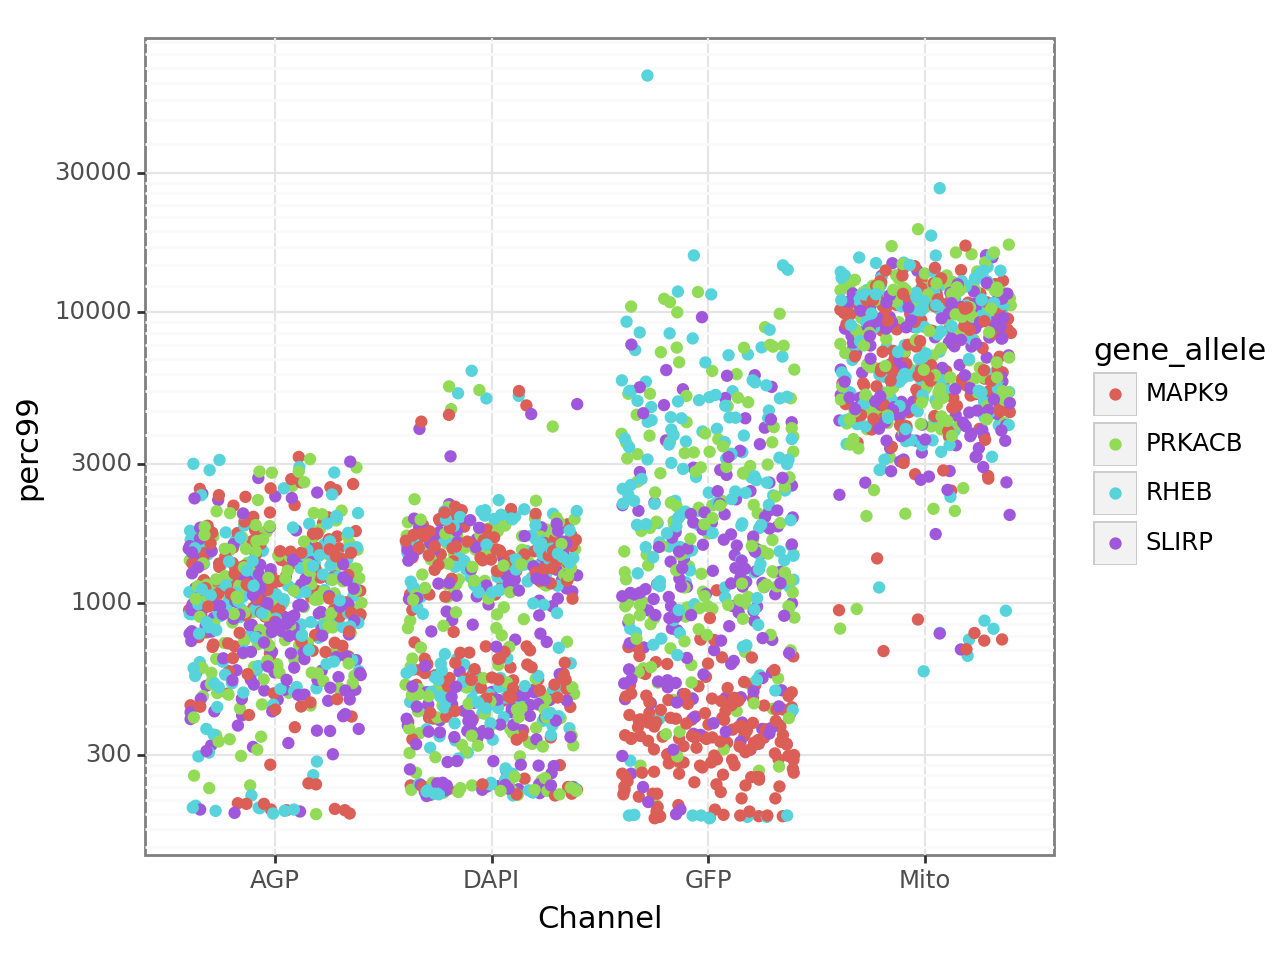

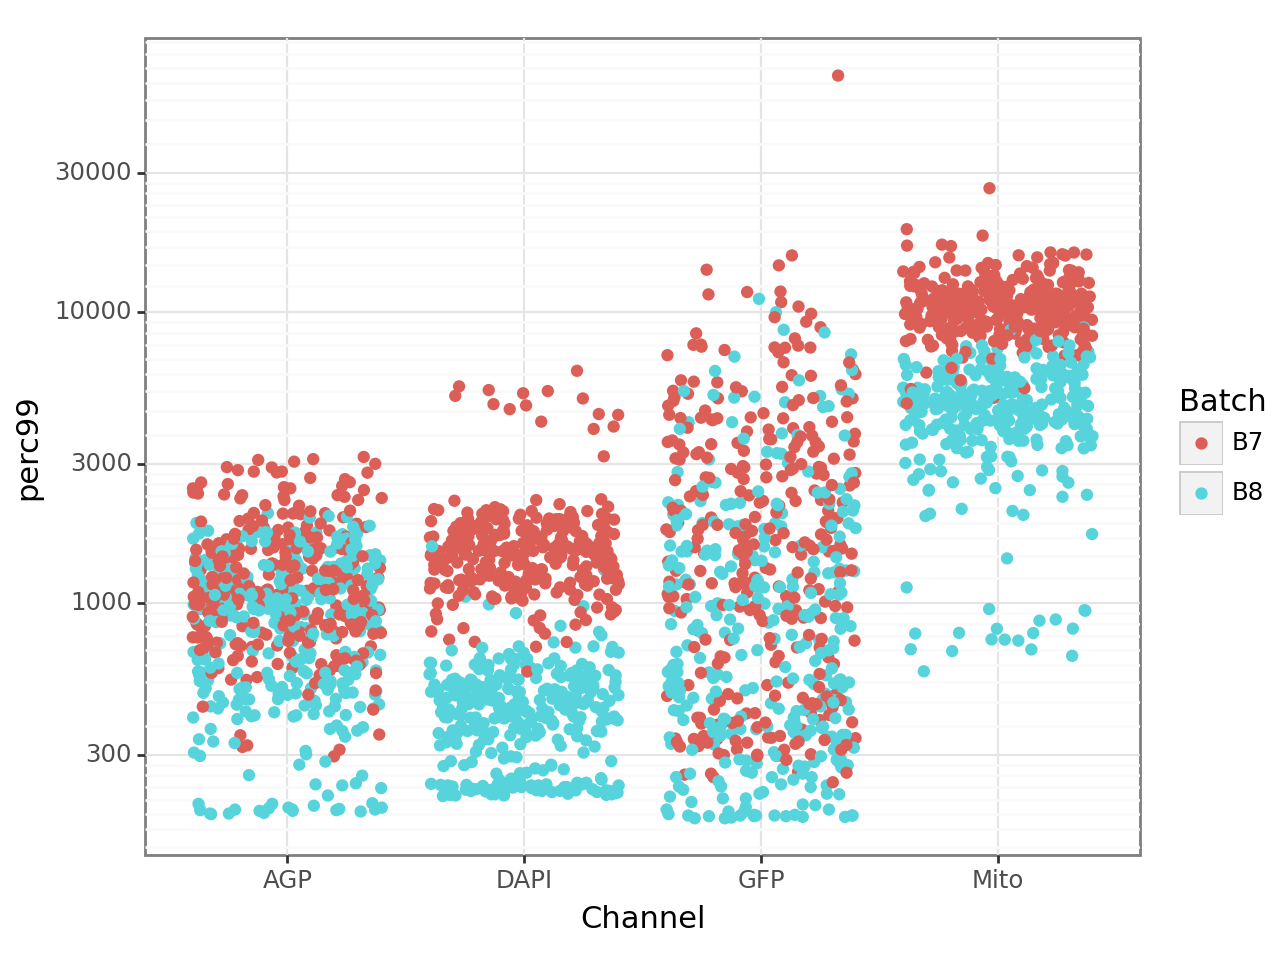

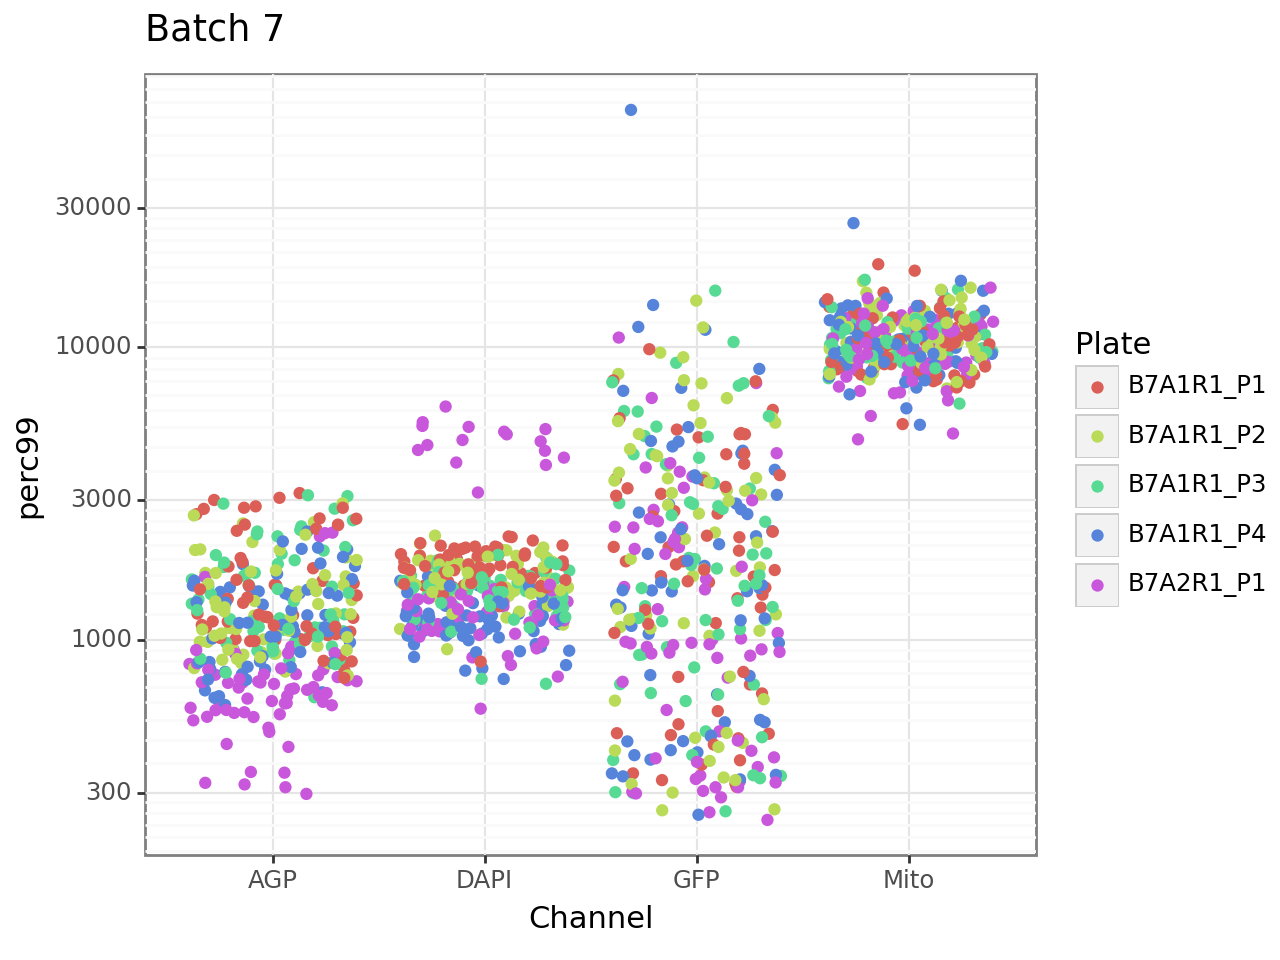

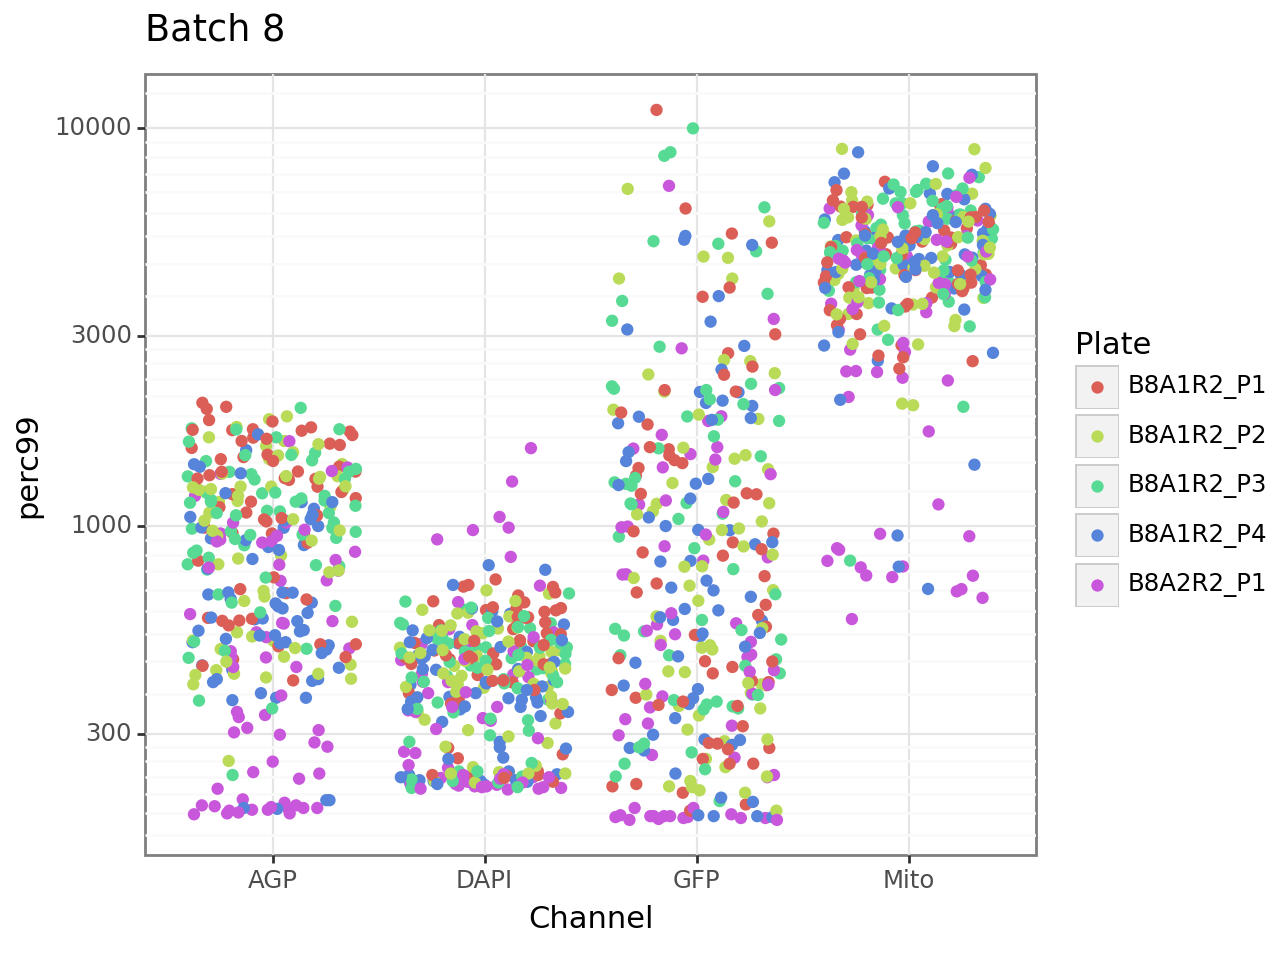

In [31]:
# make plots of well_percs
from plotnine import *

well_percs = well_percs.sample(fraction=1.0, shuffle=True)

plot1 = (ggplot(well_percs)
         + aes(x="Channel", y="perc99", color="gene_allele")
         + geom_jitter()
         + scale_y_log10()
         + theme_bw())
print((plot1))

plot2 = (ggplot(well_percs)
         + aes(x="Channel", y="perc99", color="Batch")
         + geom_jitter()
         + scale_y_log10()
         + theme_bw())
print((plot2))

plot3 = (ggplot(well_percs.filter(pl.col("Batch") == "B7"))
         + aes(x="Channel", y="perc99", color="Plate")
         + geom_jitter()
         + scale_y_log10()
         + ggtitle("Batch 7")
         + theme_bw())
print((plot3))

plot4 = (ggplot(well_percs.filter(pl.col("Batch") == "B8"))
         + aes(x="Channel", y="perc99", color="Plate")
         + geom_jitter()
         + scale_y_log10()
         + ggtitle("Batch 8")
         + theme_bw())
print((plot4))

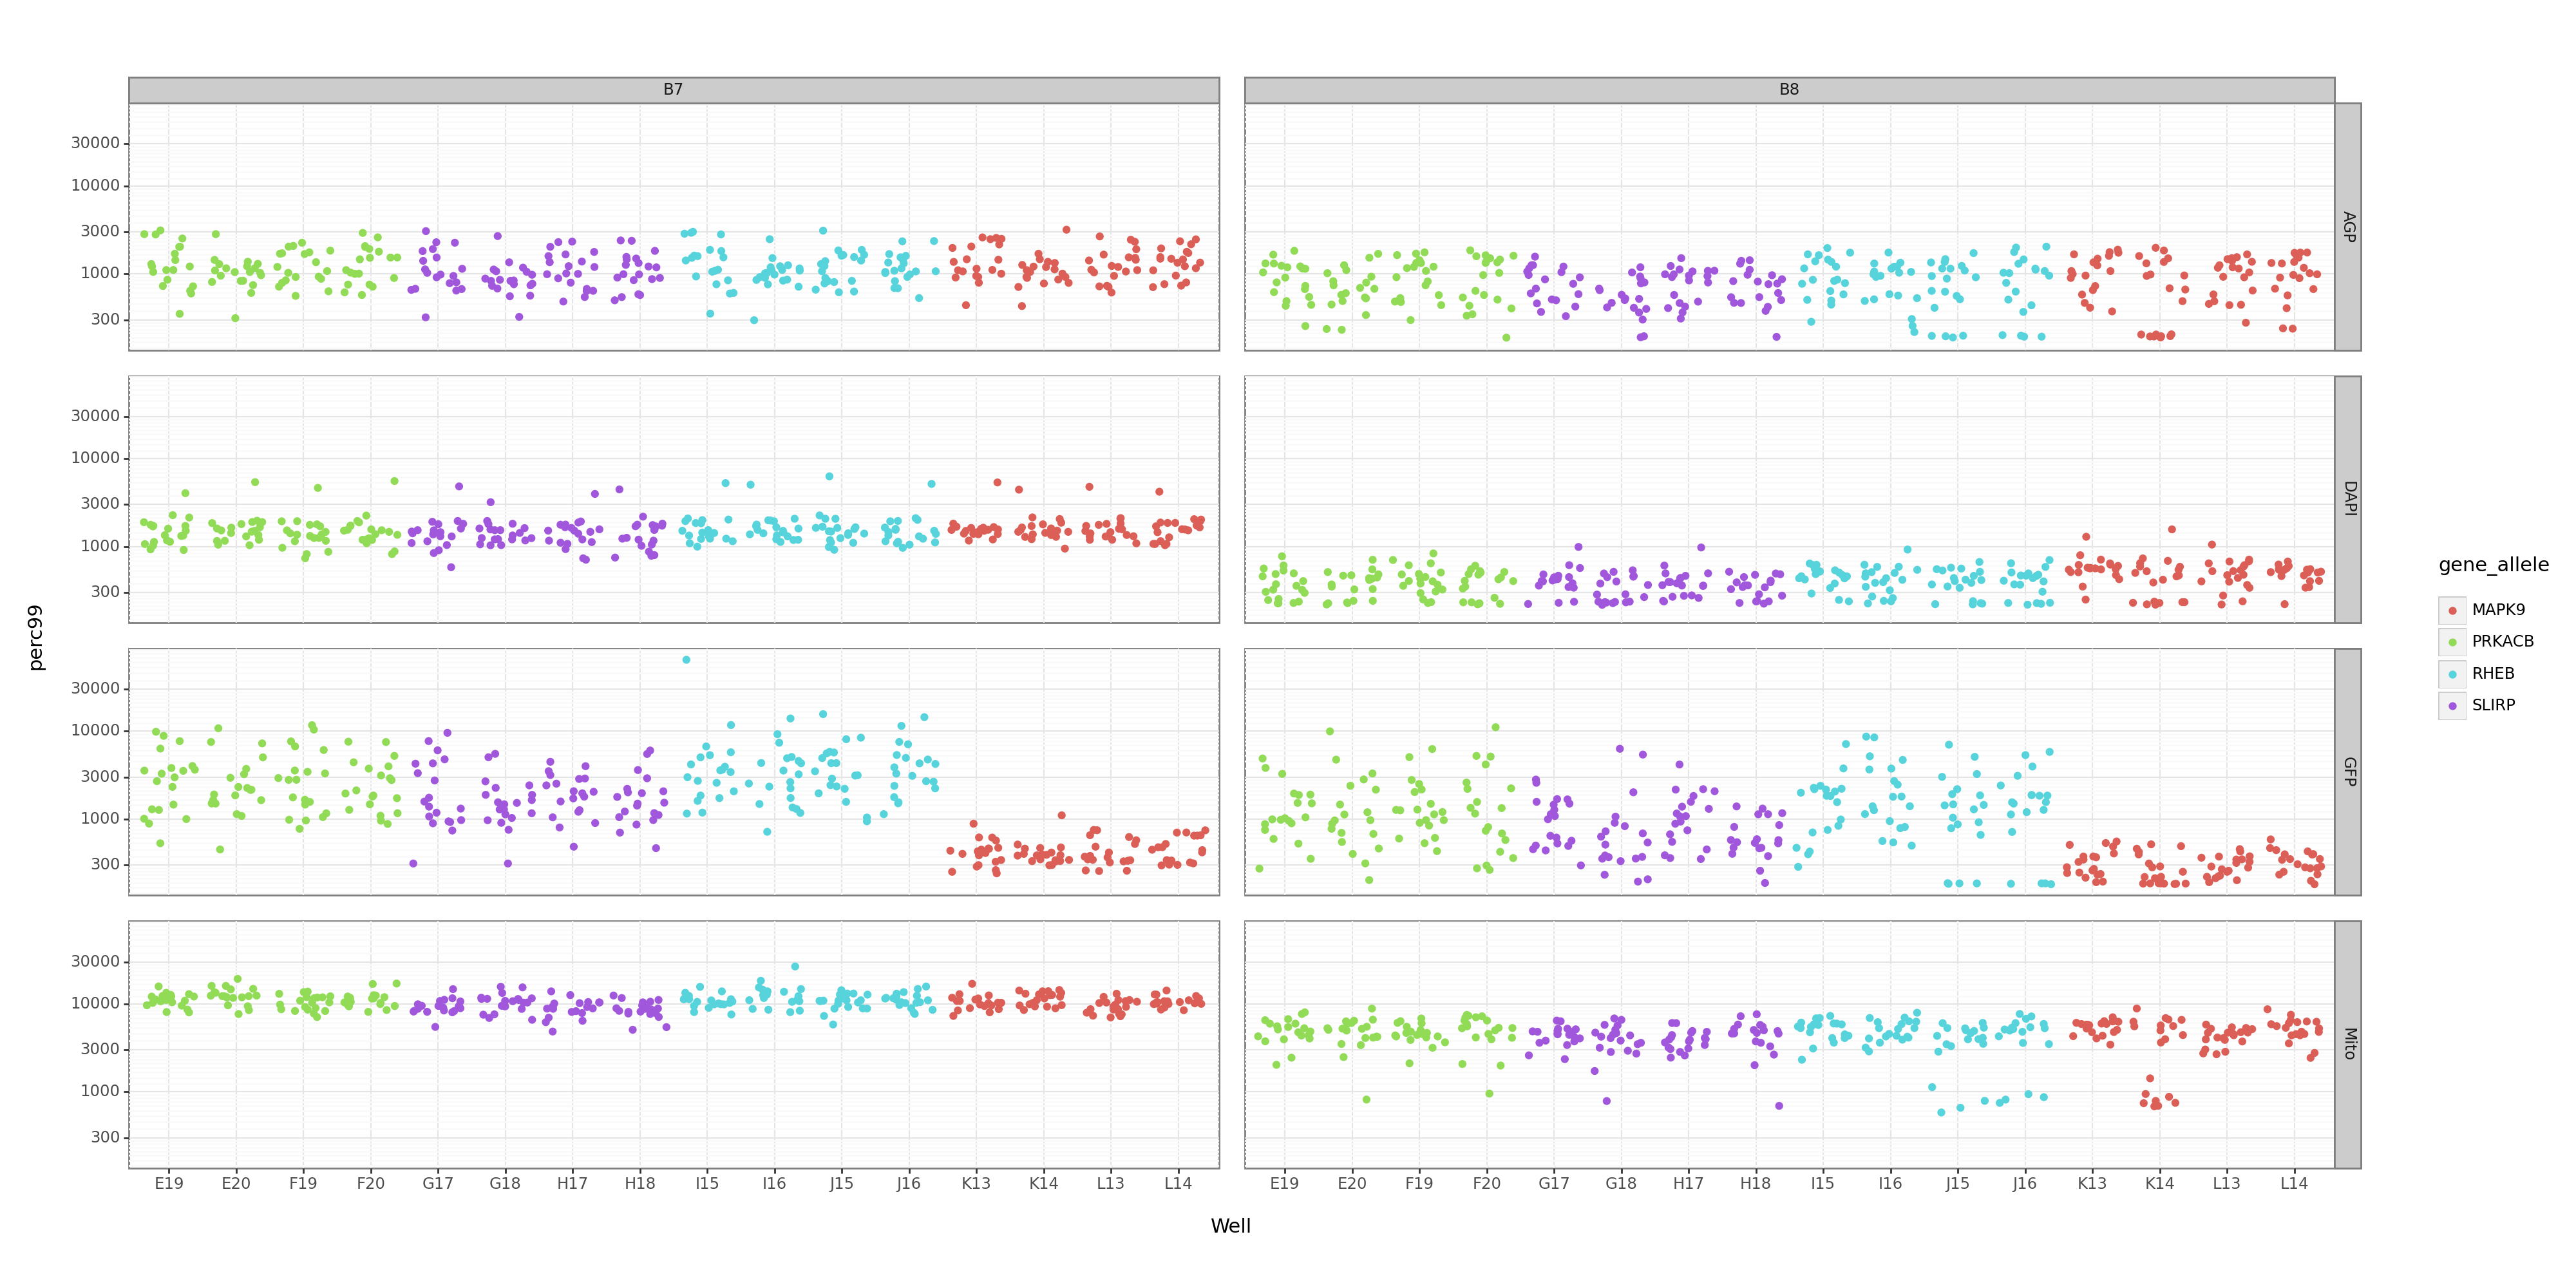

In [37]:
import plotnine as p9
p9.options.figure_size = (20,10)
plot1 = (ggplot(well_percs)
         + aes(x="Well", y="perc99", color="gene_allele")
         + geom_jitter()
         + scale_y_log10()
         + facet_grid(facets="Channel ~ Batch")
         + theme_bw())
print((plot1))

In [6]:
# Plot multiple wells

img_df = allele_percs.select(["Plate", "Replicate", "gene_allele"]).with_columns(
    pl.lit("05").alias("Site"),
    pl.col("Plate").str.slice(0,6).alias("Batch")
).join(nc_alleles.select(["Plate", "gene_allele", "Well"]), on=["Plate", "gene_allele"]).unique()

img_df.shape

(640, 6)

In [7]:
# get highest percentile for each channel
channel_dict = allele_percs.group_by(["Channel"]).agg(
    pl.col("perc99").max()
).with_columns(
    pl.col('perc99').cast(int)  # Cast perc99 values to int for exact output as asked
).to_dict(as_series=False)

channel_dict = dict(zip(channel_dict['Channel'], channel_dict['perc99']))

In [ ]:
# plot middle image for all NCs
plates = img_df.select("Plate").to_series().unique().to_list()
alleles = img_df.select("gene_allele").to_series().unique().to_list()
channels = ["AGP", "DAPI", "GFP", "Mito"]

for allele in alleles:
    for channel in channels:
        max_intensity = channel_dict[channel]
        for plate in plates:
            
            plot_nm = f"{allele}_{channel}_{plate}.png"
            print(plot_nm)
            
            plot_img = img_df.filter((pl.col("gene_allele") == allele) 
                         & (pl.col("Plate") == plate) 
                         ).sort(["Replicate", "Well"])
            
            di.plotMultiImages(plot_img, channel, max_intensity, 4, display=False, plotpath=f"{plot_dir}/{plot_nm}")

In [8]:
tcs = pm_df.filter(pl.col("control_type") == "TC").rename({
    "well_position": "Well",
    "plate_map_name": "Plate"
}).with_columns(
    pl.lit("TC").alias("gene_allele"),
    pl.lit("05").alias("Site"),
    pl.col("Plate").str.slice(0,6).alias("Batch")
)

rep_df = pl.DataFrame({
    "gene_allele": ["TC", "TC", "TC", "TC"],
    "Replicate": ["T1", "T2", "T3", "T4"]
})

tcs = tcs.join(rep_df, on="gene_allele")

Next, make plots of the TCs. 

In [ ]:
plates = img_df.select("Plate").to_series().unique().to_list()
channels = ["AGP"]

for channel in channels:
    max_intensity = channel_dict[channel]
    for plate in plates:
        
        plot_nm = f"TC_{channel}_{plate}.png"
        print(plot_nm)
        
        plot_img = tcs.filter(pl.col("Plate") == plate).sort(["Replicate", "Well"])
        
        di.plotMultiImages(plot_img, channel, max_intensity, 4, display=False, plotpath=f"{plot_dir}/{plot_nm}")

## Plot with percentiles calculated per platemap

In [9]:
# get highest percentile for each channel
plate_dict = []
for plate in plates:
    temp_percs = well_percs.filter(pl.col("Plate") == plate)
    channel_dict = temp_percs.group_by("Channel").agg(
        pl.col("perc99").max()
    ).with_columns(
        pl.col('perc99').cast(int)  # Cast perc99 values to int for exact output as asked
    ).to_dict(as_series=False)
    channel_dict = dict(zip(channel_dict['Channel'], channel_dict['perc99']))
    plate_dict.append(channel_dict)
    
plate_dict = dict(zip(plates, plate_dict))

In [ ]:
# plot middle image for all NCs
plot_dir = "/dgx1nas1/storage/data/jess/varchamp/images/control_qaqc_scaleplate"

plates = img_df.select("Plate").to_series().unique().to_list()
alleles = img_df.select("gene_allele").to_series().unique().to_list()
channels = ["AGP", "DAPI", "Mito"]

for allele in alleles:
    for channel in channels:
        for plate in plates:
            
            max_intensity = plate_dict[plate][channel]
            plot_nm = f"{allele}_{channel}_{plate}.png"
            print(plot_nm)
            
            plot_img = img_df.filter((pl.col("gene_allele") == allele) 
                         & (pl.col("Plate") == plate) 
                         ).sort(["Replicate", "Well"])
            
            di.plotMultiImages(plot_img, channel, max_intensity, 4, display=False, plotpath=f"{plot_dir}/{plot_nm}")

In [17]:
allele_dict = well_percs.filter(pl.col("Channel") == "GFP").group_by(["gene_allele"]).agg(
    pl.col("perc95").max()
).with_columns(
    pl.col('perc95').cast(int)  # Cast perc99 values to int for exact output as asked
).to_dict(as_series=False)

allele_dict = dict(zip(allele_dict['gene_allele'], allele_dict['perc95']))

In [ ]:
# plot middle image for GFP channel of all NCs
plot_dir = "/dgx1nas1/storage/data/jess/varchamp/images/control_qaqc_scaleallele95"
Path(plot_dir).mkdir(parents=True, exist_ok=True)

plates = img_df.select("Plate").to_series().unique().to_list()
alleles = img_df.select("gene_allele").to_series().unique().to_list()
channels = ["GFP"]

for allele in alleles:
    max_intensity = allele_dict[allele]
    for channel in channels:
        for plate in plates:
            
            plot_nm = f"{allele}_{channel}_{plate}.png"
            print(plot_nm)
            
            plot_img = img_df.filter((pl.col("gene_allele") == allele) 
                         & (pl.col("Plate") == plate) 
                         ).sort(["Replicate", "Well"])
            
            di.plotMultiImages(plot_img, channel, max_intensity, 4, display=False, plotpath=f"{plot_dir}/{plot_nm}")